# Sentiment Analysis with Deep Learning using BERT(SMILE Twitter dataset)






# 0-Setting environmnet

In [1]:
!pip install wget # we will use this to download the raw dataset

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f7969cb8647462901b8887e329dcbcda71022d037aefad47c22370f61e092dd7
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import pandas as pd
import wget
import torch
from transformers import BertForSequenceClassification
from transformers import  get_linear_schedule_with_warmup
import tqdm
from tqdm import tqdm  # Import the tqdm function
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
print("[INFO] All packages imported successfully")

[INFO] All packages imported successfully


In [3]:
#ensure results are reproducable
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 1-Data Preprocessinng

## Exploratory Data Analysis and Preprocessing

We will use the SMILE Twitter dataset.

Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2


In [4]:
url="https://raw.githubusercontent.com/Walid-Ahmed/Sentiment-Analysis-with-BERT-on-SMILE-Twitter-dataset/main/smileannotationsfinal.csv"
file=wget.download(url)

In [46]:
df = pd.read_csv("smileannotationsfinal.csv", names=['id', 'text', 'category'])


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3085 non-null   int64 
 1   text      3085 non-null   object
 2   category  3085 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.4+ KB


In [7]:
df.head()

,id,text,category
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [51]:
# Drop column 'id'
df = df.drop('id', axis=1)

In [53]:
# Selecting and printing 5 random rows
random_rows = df.sample(n=5)
print(random_rows)

                                                   text   category
1365  @Tate the whole Magritte exhibition @tateliver...     nocode
2397  We enjoyed the exhibition, but we'd have liked...  happy|sad
1329  Capital day with @KMHyland @britishmuseum bein...      happy
847   Frames in Focus: Sansovino Frames ... and so m...     nocode
1111  Off to London for #CivilisedBodies @ucl and th...     nocode


In [9]:
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [10]:
# Values to be removed
values_to_remove = ["nocode",'happy|surprise', 'happy|sad',"disgust|angry","sad|disgust","sad|angry","sad|disgust|angry"]

# Remove rows where column 'category' has values from values_to_remove
df = df[~df['category'].isin(values_to_remove)]


In [11]:
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [12]:
# Convert string values in 'category' to unique integer values
df['label'],uniques = pd.factorize(df['category'])

In [13]:
# Create a mapping from integer values to original category labels
label_to_category = {index: label for index, label in enumerate(uniques)}

# To get the reverse mapping from category labels to integer values
category_to_label = {label: index for index, label in label_to_category.items()}


In [14]:
print(uniques)
print(label_to_category)
print(category_to_label)


Index(['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise'], dtype='object')
{0: 'happy', 1: 'not-relevant', 2: 'angry', 3: 'disgust', 4: 'sad', 5: 'surprise'}
{'happy': 0, 'not-relevant': 1, 'angry': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}


In [43]:
# Selecting and printing 5 random rows
random_rows = df.sample(n=5)
print(random_rows)

                                                   text category  label
145   Wonderful book from trip to the @britishmuseum...    happy      0
434   @PamHartshorne @britishmuseum  Sounds wonderfu...    happy      0
2292  @psframes enjoyed the Sansovino Frames! @Natio...    happy      0
1398  Workshop @britishmuseum today on Manchu Money ...    happy      0
1284  People who &lt;3 &amp; care about paintings VS...    angry      2


In [16]:
# Get the number of unique values in the 'labels' column
num_unique_values = df['label'].nunique()

In [17]:
unique_values = df['category'].unique().tolist()


In [18]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    df.text.values,
    df.label.values,
    test_size = 0.15,
    random_state = 17,
    stratify = df.label.values
)

## Tokenization

In [21]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

The BertTokenizer.from_pretrained function is used to load a tokenizer pre-trained on the BERT (Bidirectional Encoder Representations from Transformers) model. This tokenizer is designed to properly handle the preprocessing of text before it is fed into a BERT model. The do_lower_case=True parameter ensures that the text is converted to lowercase before tokenization, which is consistent with the training of the 'bert-base-uncased' model.

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
# Special tokens
cls_token = tokenizer.cls_token
sep_token = tokenizer.sep_token
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id

print(f"CLS token: {cls_token}, ID: {cls_token_id}")
print(f"SEP token: {sep_token}, ID: {sep_token_id}")

CLS token: [CLS], ID: 101
SEP token: [SEP], ID: 102


tokenizer.encode_plus is used to encode the text directly into the format expected by the BERT model,

including:
Token IDs: numeric representations of the tokens suitable for input to the model.
Attention masks: binary mask indicating the position of the padded indices so the model does not attend to them.

Special tokens: [CLS] and [SEP] tokens added to the start and end of the sentence, respectively.

In [25]:
# Example text
text = "Here's an example to demonstrate how the tokenizer works."

# Tokenize the text
tokenized_text = tokenizer.tokenize(text)

# Print the tokenized text
print(tokenized_text)

# Convert tokens to their corresponding IDs in the BERT vocabulary
input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)

# Print the token IDs
print(input_ids)

# Encoding text directly to get dictionary of token IDs, attention masks, etc.
encoded_input = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors="pt")

# Print the encoded inputs
print(encoded_input)

['here', "'", 's', 'an', 'example', 'to', 'demonstrate', 'how', 'the', 'token', '##izer', 'works', '.']
[2182, 1005, 1055, 2019, 2742, 2000, 10580, 2129, 1996, 19204, 17629, 2573, 1012]
{'input_ids': tensor([[  101,  2182,  1005,  1055,  2019,  2742,  2000, 10580,  2129,  1996,
         19204, 17629,  2573,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


## How token_type_ids Work?

Typically, token_type_ids are a sequence of binary values (i.e., 0 or 1) of the same length as the input tokens.
A value of 0 might be used for the first sequence, and 1 for the second sequence. For single-sequence tasks, token_type_ids might be all zeros.

## How attention_mask Works?

The attention_mask is an array (or tensor) of binary values (1s and 0s) with the same length as the input sequence.
A value of 1 indicates that the corresponding token is a part of the input (and should be paid attention to), whereas a 0 indicates a padding token (which should be ignored by the attention mechanism).
During the attention calculations within the model, the mask is applied to effectively nullify the effect of padding tokens by setting their attention scores to a very large negative value, making their resulting softmax scores (and thus their contribution to the attention weighted sum) virtually zero.

## Enode training and validation text

In [26]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens = True,
    return_attention_mask = True,
    pad_to_max_length = True,
    max_length = 256,
    return_tensors = 'pt'
    ,truncation=True
)

In [27]:
encoded_data_val = tokenizer.batch_encode_plus(
    X_val,
    add_special_tokens = True,
    return_attention_mask = True,
    max_length = 256,
    return_tensors = 'pt',
    padding=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2663: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [28]:
# Viewing the contents
input_ids = encoded_data_train['input_ids']
attention_masks = encoded_data_train['attention_mask']

# To view a specific entry, for example, the first input
print(f"First input's encoded IDs: {input_ids[0]}")
print("-----------------------------------------------------------------------------------")
print(f"First input's attention mask: {attention_masks[0]}")

First input's encoded IDs: tensor([  101,  1030,  4459,  2595,  6834,  1030, 11268,  5558, 19281,  2378,
         1030,  2329,  7606, 14820,  1045,  2165,  2023,  3861,  2096,  1045,
         2001,  1999,  1996,  8756,  1012,  4658,  4355,  2712,  6071,  2412,
         1012,  8299,  1024,  1013,  1013,  1056,  1012,  2522,  1013,  7861,
         2094,  9759,  2860,  7959, 10322,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  

In [29]:
# If you want to see the tokens corresponding to the first input's encoded IDs
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokens)

['[CLS]', '@', 'stephen', '##x', '##king', '@', 'prof', '##jo', '##eca', '##in', '@', 'british', '##mus', '##eum', 'i', 'took', 'this', 'picture', 'while', 'i', 'was', 'in', 'the', 'archive', '.', 'cool', '##est', 'sea', 'monster', 'ever', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', 'em', '##d', '##zu', '##w', '##fe', '##bb', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

## create dataset for training and validation

In [30]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

In [31]:
labels_train = torch.tensor(y_train)
labels_val = torch.tensor(y_val)

In [32]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [33]:
# Save the datasets
import os

# Define the folder name
folder_name = "data"

# Check if the folder exists, if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print("Folder 'data' created.")
else:
    print("Folder 'data' already exists.")
torch.save(dataset_train, 'data/dataset_train.pt')
torch.save(dataset_val, 'data/dataset_val.pt')

Folder 'data' created.


In [58]:
  # Prepare the data to be stored in JSON format
  data_to_store = {
      'num_unique_values': num_unique_values,
      'unique_values': unique_values,
      'label_to_category':label_to_category
  }

  # Write the data to a JSON file
  with open('data_info.json', 'w') as json_file:
      json.dump(data_to_store, json_file, indent=4)

  print("Data Info stored in data_info.json successfully.")

Data Info stored in data_info.json successfully.


## Data prepeocessing as a single script

In [34]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import torch
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import numpy as np
def preprocess(data_path):
  df = pd.read_csv(data_path, names=['id', 'text', 'category'])
  # Drop column 'id'
  df = df.drop('id', axis=1)
  # Values to be removed
  values_to_remove = ["nocode",'happy|surprise', 'happy|sad',"disgust|angry","sad|disgust","sad|angry","sad|disgust|angry"]
  # Remove rows where column 'category' has values from values_to_remove
  df = df[~df['category'].isin(values_to_remove)]
  # Convert string values in 'category' to unique integer values
  df['label'],uniques = pd.factorize(df['category'])
  # Create a mapping from integer values to original category labels
  label_to_category = {index: label for index, label in enumerate(uniques)}
  # To get the reverse mapping from category labels to integer values
  category_to_label = {label: index for index, label in label_to_category.items()}
  # Get the number of unique values in the 'labels' column
  num_unique_values = df['label'].nunique()
  unique_values = df['category'].unique().tolist()
  X_train, X_val, y_train, y_val = train_test_split(
    df.text.values,
    df.label.values,
    test_size = 0.15,
    random_state = 17,
    stratify = df.label.values)
  return X_train, X_val, y_train, y_val,num_unique_values,unique_values,label_to_category

def tokenize(X_train,X_val):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  encoded_data_train = tokenizer.batch_encode_plus(
      X_train,
      add_special_tokens = True,
      return_attention_mask = True,
      max_length = 256,
      padding='max_length',
      return_tensors = 'pt'
      ,truncation=True)

  encoded_data_val = tokenizer.batch_encode_plus(
    X_val,
    add_special_tokens = True,
    return_attention_mask = True,

    return_tensors = 'pt',
    padding='max_length',
    max_length = 256,)
  return encoded_data_train,encoded_data_val

def create_save_dataset(encoded_data_train,encoded_data_val,y_train,y_val,label_to_category):

  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  input_ids_val = encoded_data_val['input_ids']
  attention_masks_val = encoded_data_val['attention_mask']

  # Find unique elements
  unique_elements = np.unique(y_train)
  # Get the number of unique elements
  num_unique_values = len(unique_elements)


  labels_train = torch.tensor(y_train)
  labels_val = torch.tensor(y_val)
  dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

  # Save the datasets

  # Define the folder name
  folder_name = "data"

  # Check if the folder exists, if not, create it
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)
      print("Folder 'data' created.")
  else:
      print("Folder 'data' already exists.")
  torch.save(dataset_train, 'data/dataset_train.pt')
  torch.save(dataset_val, 'data/dataset_val.pt')
  print("[INFO] Fils  dataset_train.pt and  dataset_val.pt saved to folder data")


  # Prepare the data to be stored in JSON format
  data_to_store = {
      'num_unique_values': num_unique_values,
      'unique_values': unique_values,
      'label_to_category':label_to_category
  }

  # Write the data to a JSON file
  with open('data_info.json', 'w') as json_file:
      json.dump(data_to_store, json_file, indent=4)

  print("Data Info stored in data_info.json successfully.")


In [5]:
X_train, X_val, y_train, y_val,num_unique_values,unique_values,label_to_category=preprocess("smileannotationsfinal.csv")
encoded_data_train,encoded_data_val=tokenize(X_train,X_val)
create_save_dataset(encoded_data_train,encoded_data_val,y_train,y_val,label_to_category)

Folder 'data' created.
[INFO] Fils  dataset_train.pt and  dataset_val.pt saved to folder data
Data Info stored in data_info.json successfully.


# 2-Training

In [35]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


## Setting up BERT Pretrained Model

In [36]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = num_unique_values,
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [38]:
print(type((model)))
print("-"*70)
print(model)

<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
----------------------------------------------------------------------
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output

## Creating Data Loaders

In [39]:
batch_size = 4 #32
dataloader_train = DataLoader(
    dataset_train,
    sampler = RandomSampler(dataset_train),
    batch_size = batch_size
)

dataloader_validation = DataLoader(
    dataset_val,
    sampler = SequentialSampler(dataset_val),
    batch_size = 32
)

## Setting optimizer

In [40]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-5, #2e-5 to 5e-5
    eps = 1e-8
)


## Training using Pytorch

In [42]:
# Store the average loss after each epoch so we can plot them.
loss_values = []
epochs=10
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch}")):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        model.zero_grad()

        outputs = model(**inputs)
        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(dataloader_train)
    loss_values.append(avg_train_loss)

    print(f"Epoch {epoch} | Average Training Loss: {avg_train_loss}")

Epoch 1: 100%|██████████| 315/315 [01:01<00:00,  5.11it/s]


Epoch 1 | Average Training Loss: 0.7344699287698382


Epoch 2: 100%|██████████| 315/315 [01:01<00:00,  5.09it/s]


Epoch 2 | Average Training Loss: 0.4244885874291261


Epoch 3: 100%|██████████| 315/315 [01:01<00:00,  5.10it/s]


Epoch 3 | Average Training Loss: 0.25822140106724367


Epoch 4: 100%|██████████| 315/315 [01:01<00:00,  5.12it/s]


Epoch 4 | Average Training Loss: 0.17016460233855815


Epoch 5: 100%|██████████| 315/315 [01:01<00:00,  5.11it/s]


Epoch 5 | Average Training Loss: 0.09883373414151489


Epoch 6: 100%|██████████| 315/315 [01:01<00:00,  5.12it/s]


Epoch 6 | Average Training Loss: 0.0604415631209988


Epoch 7: 100%|██████████| 315/315 [01:01<00:00,  5.11it/s]


Epoch 7 | Average Training Loss: 0.044727887626781704


Epoch 8: 100%|██████████| 315/315 [01:01<00:00,  5.12it/s]


Epoch 8 | Average Training Loss: 0.03560302292610267


Epoch 9: 100%|██████████| 315/315 [01:01<00:00,  5.11it/s]


Epoch 9 | Average Training Loss: 0.017495415625827654


Epoch 10: 100%|██████████| 315/315 [01:01<00:00,  5.12it/s]

Epoch 10 | Average Training Loss: 0.01606700157983199


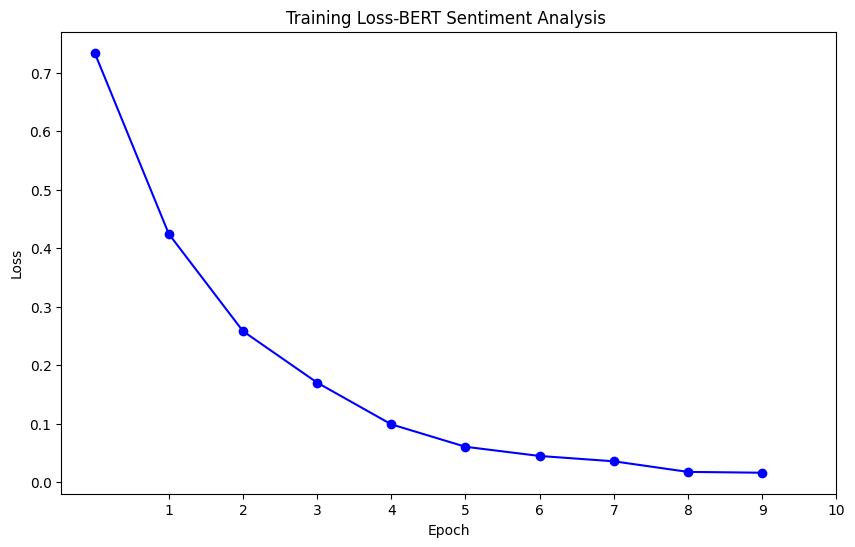

In [54]:

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_values, 'b-o')

plt.title("Training Loss-BERT Sentiment Analysis ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, epochs+1))
plt.show()

In [55]:
torch.save(model.state_dict(), f'Bert_ft.pt')

## Training as single function

In [6]:
import torch
from transformers import BertForSequenceClassification
from transformers import  get_linear_schedule_with_warmup
import tqdm
from tqdm import tqdm  # Import the tqdm function
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import json

def train():

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




  # Load the data from the JSON file
  with open('data_info.json', 'r') as json_file:
      loaded_data = json.load(json_file)

  # Extract values into variables
  num_unique_values = loaded_data['num_unique_values']
  unique_values = loaded_data['unique_values']

  # Print the loaded data to verify
  print(f"Number of Unique Values: {num_unique_values}")
  print(f"Unique Values: {unique_values}")

  model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = num_unique_values,
    output_attentions = False,
    output_hidden_states = False)
  model.to(device)

  print("-"*70)
  print(model)
  print("-"*70)


  optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-5, #2e-5 to 5e-5
    eps = 1e-8)

  epochs=10
  batch_size = 4 #32


  dataset_train=torch.load('data/dataset_train.pt')
  dataset_val=torch.load('data/dataset_val.pt')

  dataloader_train = DataLoader(
      dataset_train,
      sampler = RandomSampler(dataset_train),
      batch_size = batch_size
  )

  dataloader_validation = DataLoader(
      dataset_val,
      sampler = SequentialSampler(dataset_val),
      batch_size = 32
  )

    # Store the average loss after each epoch so we can plot them.
  loss_values = []

  for epoch in range(1, epochs+1):
      model.train()
      total_loss = 0

      for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch}")):
          batch = tuple(t.to(device) for t in batch)
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2]}

          model.zero_grad()

          outputs = model(**inputs)
          loss = outputs[0]
          total_loss += loss.item()

          loss.backward()
          optimizer.step()

      avg_train_loss = total_loss / len(dataloader_train)
      loss_values.append(avg_train_loss)

      print(f"Epoch {epoch} | Average Training Loss: {avg_train_loss}")

  #save model
  torch.save(model.state_dict(), f'Bert_ft.pt')
  print("[INFO] Model saved to file  Bert_ft.pt")
  plot(loss_values,epochs)

In [7]:
def plot(loss_values,epochs):
  # Plotting the training loss
  plt.figure(figsize=(10, 6))
  plt.plot(loss_values, 'b-o')

  plt.title("Training Loss-BERT Sentiment Analysis ")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.xticks(range(1, epochs+1))


    # Define the folder name
  folder_name = "results"

  # Check if the folder exists, if not, create it
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)
      print("Folder results created.")
  else:
      print("Folder results already exists.")
  plt.savefig(os.path.join("results", 'Training_Loss.png'))
  print("[INFO] Training Loss saved to file Training_Loss.png in results folder")
  plt.show()

Number of Unique Values: 6
Unique Values: ['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise']


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=

Epoch 1: 100%|██████████| 315/315 [00:59<00:00,  5.26it/s]


Epoch 1 | Average Training Loss: 0.7335045443640815


Epoch 2: 100%|██████████| 315/315 [01:01<00:00,  5.09it/s]


Epoch 2 | Average Training Loss: 0.42142631872778846


Epoch 3: 100%|██████████| 315/315 [01:01<00:00,  5.12it/s]


Epoch 3 | Average Training Loss: 0.25903581014228244


Epoch 4: 100%|██████████| 315/315 [01:02<00:00,  5.08it/s]


Epoch 4 | Average Training Loss: 0.16544622816884566


Epoch 5: 100%|██████████| 315/315 [01:01<00:00,  5.10it/s]


Epoch 5 | Average Training Loss: 0.10547339551682983


Epoch 6: 100%|██████████| 315/315 [01:01<00:00,  5.10it/s]


Epoch 6 | Average Training Loss: 0.06755344281786137


Epoch 7: 100%|██████████| 315/315 [01:01<00:00,  5.10it/s]


Epoch 7 | Average Training Loss: 0.03736768411694183


Epoch 8: 100%|██████████| 315/315 [01:01<00:00,  5.11it/s]


Epoch 8 | Average Training Loss: 0.0371930786260655


Epoch 9: 100%|██████████| 315/315 [01:01<00:00,  5.11it/s]


Epoch 9 | Average Training Loss: 0.039460644911279874


Epoch 10: 100%|██████████| 315/315 [01:01<00:00,  5.10it/s]


Epoch 10 | Average Training Loss: 0.017886724392144334
[INFO] Model saved to file  Bert_ft.pt
Folder results created.


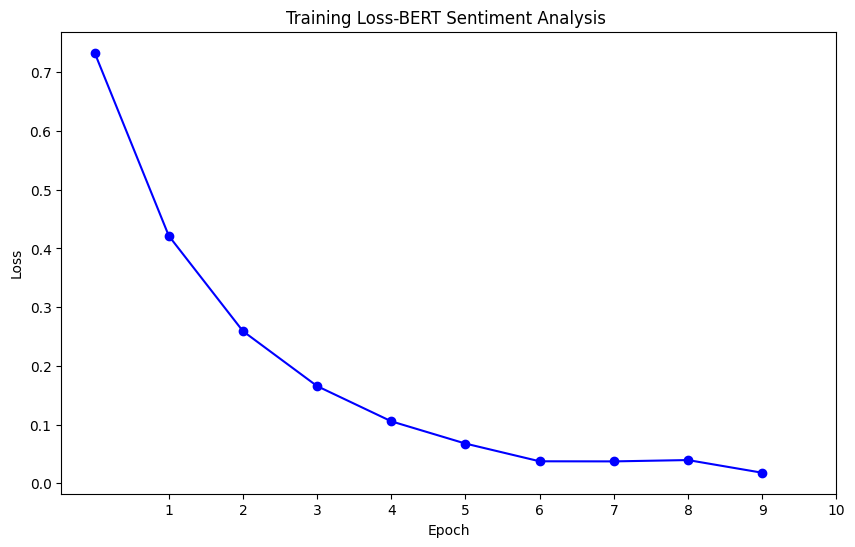

In [8]:
train()


# 3-Evaluate model

In [59]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
import json
import seaborn as sns
import os

def evalModel():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  num_unique_values=6
  path_to_model="Bert_ft.pt"


  # Load the data from the JSON file
  with open('data_info.json', 'r') as json_file:
      loaded_data = json.load(json_file)

  # Extract values into variables
  num_unique_values = loaded_data['num_unique_values']
  unique_values = loaded_data['unique_values']
  label_to_category=loaded_data['label_to_category']


  # Print the loaded data to verify
  print(f"Number of Unique Values: {num_unique_values}")
  print(f"Unique Values: {unique_values}")
  print(f"label_to_category: {label_to_category}")


  # Load fine-tuned-model
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=num_unique_values,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


  state_dict= torch.load('Bert_ft.pt',
              map_location = device)
  model.load_state_dict(state_dict)

  model.eval()  # Put the model in evaluation mode
  model.to(device)


  dataset_val=torch.load('data/dataset_val.pt')

  dataloader_validation = DataLoader(
      dataset_val,
      sampler = SequentialSampler(dataset_val),
      batch_size = 32
  )

  predictions, true_labels = [], []

  with torch.no_grad():
      for batch in dataloader_validation:
          batch = tuple(b.to(device) for b in batch)
          inputs = {
              'input_ids'       : batch[0],
              'attention_mask'  : batch[1],
              'labels'          : batch[2]
          }

          outputs = model(**inputs)

          # Move logits and labels to CPU as they will be converted to numpy
          logits = outputs.logits.detach().cpu().numpy()
          label_ids = batch[2].to('cpu').numpy()

          # Store predictions and true labels
          predictions.append(logits)
          true_labels.append(label_ids)

  # Convert the predictions and labels to flat lists
  flat_predictions = np.concatenate(predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # For classification, we can use the argmax to get the predicted label
  flat_predictions = np.argmax(flat_predictions, axis=1)

  # Calculate the accuracy
  accuracy = accuracy_score(flat_true_labels, flat_predictions)
  print(f"Accuracy: {accuracy}")
  plot_save_confusion_matrix(unique_values,flat_true_labels, flat_predictions)


In [60]:
def plot_save_confusion_matrix(unique_values,flat_true_labels, flat_predictions):
  class_labels = unique_values

  # Compute the confusion matrix
  conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

  # Optionally, normalize the confusion matrix
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

  # Plotting the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
              xticklabels=class_labels,  # Set custom x-tick labels
              yticklabels=class_labels)  # Set custom y-tick labels
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Normalized Confusion Matrix')


  # Define the folder name
  folder_name = "results"

  # Check if the folder exists, if not, create it
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)
      print("Folder results created.")
  else:
      print("Folder results already exists.")
  plt.savefig(os.path.join("results", 'confusion_matrix.png'))
  plt.show()




Number of Unique Values: 6
Unique Values: ['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise']
label_to_category: {'0': 'happy', '1': 'not-relevant', '2': 'angry', '3': 'disgust', '4': 'sad', '5': 'surprise'}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8654708520179372
Folder results created.


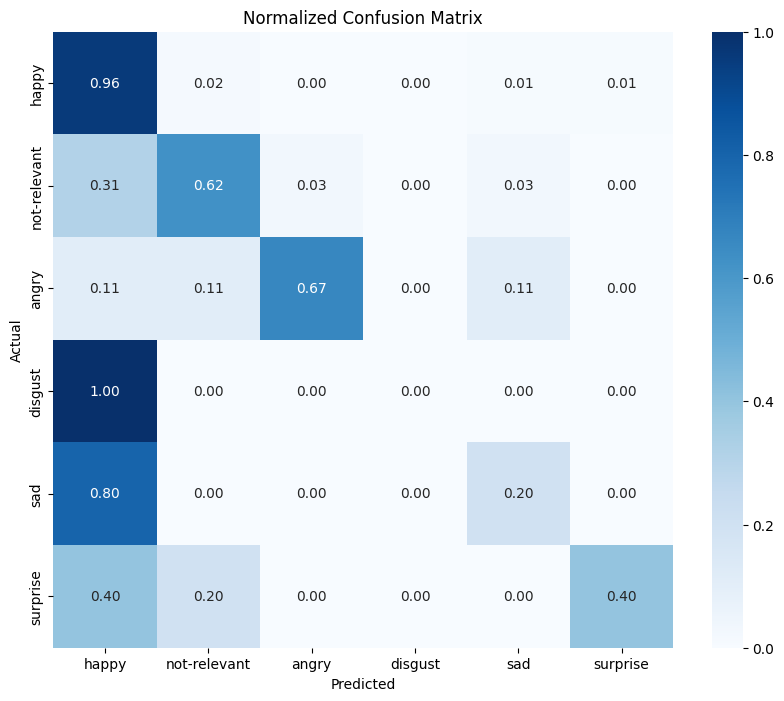

In [61]:
evalModel()

# 4-Test model on a single Tweet

In [62]:
def index_to_label(prediction_index,label_to_category):
    # Define your mapping from index to label
    label_dict = label_to_category
        # Add more labels as needed

    # Return the corresponding label for the prediction index
    return label_dict.get(str(prediction_index), "Unknown")  # Default to "Unknown" if index is not found


In [63]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch


# Function to predict the label of a tweet
def predict_label(tweet):

  # Load the data from the JSON file
  with open('data_info.json', 'r') as json_file:
      loaded_data = json.load(json_file)

  # Extract values into variables
  num_unique_values = loaded_data['num_unique_values']
  unique_values = loaded_data['unique_values']
  label_to_category=loaded_data['label_to_category']


  # Print the loaded data to verify
  print(f"Number of Unique Values: {num_unique_values}")
  print(f"Unique Values: {unique_values}")
  print(f"label_to_category: {label_to_category}")

  # Check if CUDA is available and set the device accordingly
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  print(f"Using device: {device}")
  state_dict= torch.load('Bert_ft.pt',
              map_location = device)
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=num_unique_values,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
  model.load_state_dict(state_dict)
  # Ensure the model is in evaluation mode
  model.eval()

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  # Tokenize and encode the tweet for BERT
  inputs = tokenizer.encode_plus(
        tweet,
        None,
        add_special_tokens=True,
        max_length=256,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

  # Get the input IDs and attention mask tensors
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']

  # Make prediction
  with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

  # Get the prediction (the index of the highest logit)
  prediction = torch.argmax(outputs.logits, dim=1).item()


  # Convert prediction index to label (assuming you have a way to map indices to labels)
  label = index_to_label(prediction,label_to_category)  # Implement this function based on your labels

  return label




In [64]:
# Example usage
tweet = "I am so happy"
label = predict_label(tweet)
print(f"Predicted label: {label}")

Number of Unique Values: 6
Unique Values: ['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise']
label_to_category: {'0': 'happy', '1': 'not-relevant', '2': 'angry', '3': 'disgust', '4': 'sad', '5': 'surprise'}
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In t

Predicted label: happy


In [65]:
# Example usage
tweet = "I hate this movie"
label = predict_label(tweet)
print(f"for Tweet\"{tweet}\" Predicted label: {label}")

Number of Unique Values: 6
Unique Values: ['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise']
label_to_category: {'0': 'happy', '1': 'not-relevant', '2': 'angry', '3': 'disgust', '4': 'sad', '5': 'surprise'}
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


for Tweet"I hate this movie" Predicted label: sad
